<a href="https://colab.research.google.com/github/ameenattar92/Cardiovascular-Risk-Prediction/blob/main/Pradip_Cardiovascular_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset is from an ongoing cardiovascular study on residents of the town of Framingham,
Massachusetts.

The classification goal is to predict whether the patient has a 10-year risk of
future coronary heart disease (CHD). 

The dataset provides the patients’ information. It includes
over 4,000 records and 15 attributes.
Variables
Each attribute is a potential risk factor. There are both demographic, behavioral, and medical risk
factors.

# **Data Description**
### **Demographic:**
* Sex: male or female("M" or "F")
* Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

### **Behavioral**
* is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
* Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be
considered continuous as one can have any number of cigarettes, even half a cigarette.)

### **Medical( history)**
* BP Meds: whether or not the patient was on blood pressure medication (Nominal)
* Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
* Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
* Diabetes: whether or not the patient had diabetes (Nominal)
Medical(current)
* Tot Chol: total cholesterol level (Continuous)
* Sys BP: systolic blood pressure (Continuous)
* Dia BP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in
fact discrete, yet are considered continuous because of large number of possible values.)
* Glucose: glucose level (Continuous)
Predict variable (desired target)
* 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”) -
DV

In [1]:
#Importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Capstone Project/Cardiovascular Risk Prediction - Pradip Solanki/data/data_cardiovascular_risk.csv'

In [4]:
cvs_df = pd.read_csv(path , index_col = "id")

In [5]:
cvs_df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


## **Naive Bayes Classifier** 

Let's first build naive bayes classifier to act as baseline model.

In [6]:
# check datatype
cvs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [13]:
# fill nan values

cvs_df['education'].fillna(cvs_df['education'].mode()[0], inplace=True)
cvs_df['cigsPerDay'].fillna(cvs_df['cigsPerDay'].mode()[0], inplace=True)
cvs_df['BPMeds'].fillna(cvs_df['BPMeds'].mode()[0], inplace=True)
cvs_df['totChol'].fillna(cvs_df['totChol'].mode()[0], inplace=True)
cvs_df['glucose'].fillna(cvs_df['glucose'].mode()[0], inplace=True)
cvs_df['BMI'].fillna(cvs_df['BMI'].mode()[0], inplace=True)
cvs_df['heartRate'].fillna(cvs_df['heartRate'].mode()[0], inplace=True)

In [14]:
cvs_df.isnull().sum()

age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

change categorical data from labels to numbers.

In [15]:
# 1 = Male, 0 = Female
cvs_df['sex'] = cvs_df['sex'].apply(lambda x: 1 if x=='M' else 0)

# 1 = Yes, 0 = No
cvs_df['is_smoking'] = cvs_df['is_smoking'].apply(lambda x: 1 if x=='YES' else 0)

In [16]:
X = cvs_df.drop(columns=['TenYearCHD']).values
Y = cvs_df['TenYearCHD'].values

In [17]:
X

array([[64.  ,  2.  ,  0.  , ..., 22.91, 90.  , 80.  ],
       [36.  ,  4.  ,  0.  , ..., 29.77, 72.  , 75.  ],
       [46.  ,  1.  ,  0.  , ..., 20.35, 88.  , 94.  ],
       ...,
       [44.  ,  3.  ,  0.  , ..., 28.92, 73.  , 72.  ],
       [60.  ,  1.  ,  0.  , ..., 23.01, 80.  , 85.  ],
       [54.  ,  3.  ,  0.  , ..., 29.88, 79.  , 92.  ]])

In [18]:
Y

array([1, 0, 0, ..., 1, 0, 0])

In [19]:
# perform split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [20]:
# build model and train it
naive_bayes_model = GaussianNB().fit(X_train,Y_train)

In [21]:
# check pridicted probability
train_pred_proba = naive_bayes_model.predict_proba(X_train)
test_pred_proba = naive_bayes_model.predict_proba(X_test)

# print probability
print('Train Probability: ', train_pred_proba)
print('Test Probability: ', test_pred_proba)

Train Probability:  [[9.89850726e-01 1.01492736e-02]
 [9.99424643e-01 5.75357425e-04]
 [7.40179971e-01 2.59820029e-01]
 ...
 [9.96360272e-01 3.63972811e-03]
 [9.98831463e-01 1.16853710e-03]
 [9.96611594e-01 3.38840644e-03]]
Test Probability:  [[0.98122499 0.01877501]
 [0.99646201 0.00353799]
 [0.90857568 0.09142432]
 ...
 [0.99866484 0.00133516]
 [0.99623634 0.00376366]
 [0.99747076 0.00252924]]


In [22]:
# predict values
train_preds = naive_bayes_model.predict(X_train)
test_preds = naive_bayes_model.predict(X_test)

In [23]:
# check class predictions
print('Train predict: ', train_preds)
print('Test predict: ', test_preds)

Train predict:  [0 0 0 ... 0 0 0]
Test predict:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [24]:
print(confusion_matrix(Y_train, train_preds))
print(confusion_matrix(Y_test, test_preds))

[[2159  146]
 [ 319   88]]
[[529  45]
 [ 81  23]]


[[2159  146]
 [ 319   88]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

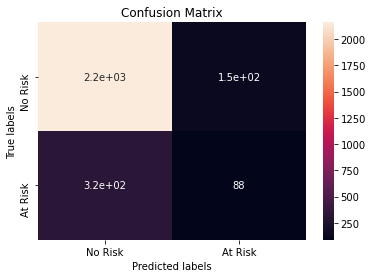

In [25]:
# Get the confusion matrix for train 
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(Y_train, train_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[529  45]
 [ 81  23]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

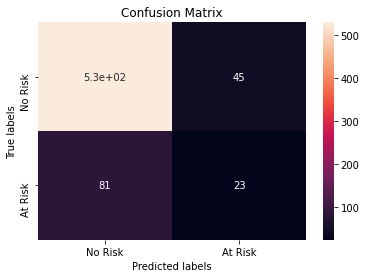

In [26]:
# Get the confusion matrix for test 
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(Y_test, test_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [27]:
# print acurracy and roc_auc score
print('ROCAUC score:', roc_auc_score(Y_test, test_preds))
print('Accuracy score:', accuracy_score(Y_test, test_preds))

# Print the classification report for train and test
print(classification_report(Y_train, train_preds))
print("\n")
print(classification_report(Y_test, test_preds))

ROCAUC score: 0.5713783168051462
Accuracy score: 0.8141592920353983
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2305
           1       0.38      0.22      0.27       407

    accuracy                           0.83      2712
   macro avg       0.62      0.58      0.59      2712
weighted avg       0.80      0.83      0.81      2712



              precision    recall  f1-score   support

           0       0.87      0.92      0.89       574
           1       0.34      0.22      0.27       104

    accuracy                           0.81       678
   macro avg       0.60      0.57      0.58       678
weighted avg       0.79      0.81      0.80       678



Since Accuracy is not good measure we will check ROCAUC score

## **Knn**

Let's build knn to check how much score improves from naive bayes classifier.

In [28]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [29]:
X_pca = pca.transform(X)

In [30]:
X_pca

array([[-12.39829734,  16.42190189, -11.87650715,   1.94779802,
         13.07076899],
       [-20.00457999,  28.91368685, -28.39478967,  -6.81743548,
         -1.23576845],
       [ 10.36902808,  -9.69303833,  22.6246395 ,   9.26679909,
          9.68102534],
       ...,
       [118.89181078,   9.39473064, -27.24096983,  -4.5095242 ,
         -3.84452576],
       [-38.35848704,  42.70762031, -24.26851965,  -5.46549212,
          4.7265479 ],
       [ 49.60041077,  -8.25866958,  16.79551834,  -5.49002896,
          8.53729838]])

In [31]:
pca.explained_variance_ratio_

array([0.57768366, 0.17551859, 0.13614209, 0.04306252, 0.03474421])

We can see that after 3rd component explained variance ratio decrease drastically so, we will use first 5 components for knn model.
Now lets find out optimal number of neighbours.

In [32]:
# perform test train split on components
X_train_comp, X_test_comp, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=0)

In [33]:
print(X.shape, Y.shape)
print(X_train_comp.shape)
print(X_test_comp.shape)

(3390, 15) (3390,)
(2712, 5)
(678, 5)


In [34]:
# calculate accuracy score for first 10 neighbors
# Setup arrays to store training and test accuracies
neighbors = 10
train_accuracy_comp = np.empty(neighbors)
test_accuracy_comp = np.empty(neighbors)

for i in range(1, neighbors + 1):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    # Fit the model
    knn.fit(X_train_comp, Y_train)
    # Compute accuracy on the training set
    train_accuracy_comp[i - 1] = knn.score(X_train_comp, Y_train)
    # Compute accuracy on the test set
    test_accuracy_comp[i - 1] = knn.score(X_test_comp, Y_test) 

In [35]:
# print accuracy
print("Train Accuracy: ", train_accuracy_comp)
print("Test Accuracy: ", test_accuracy_comp)

Train Accuracy:  [1.         0.88016224 0.88126844 0.86651917 0.86762537 0.85914454
 0.86541298 0.85914454 0.85951327 0.85619469]
Test Accuracy:  [0.7699115  0.83333333 0.7979351  0.83038348 0.8259587  0.84070796
 0.83923304 0.84513274 0.84218289 0.84660767]


Let's check accuracy score on original dataset to see the difference.

In [36]:
# perform split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [37]:
print(X.shape, Y.shape)
print(X_train.shape)
print(X_test.shape)

(3390, 15) (3390,)
(2712, 15)
(678, 15)


In [38]:
# calculate accuracy score for first 10 neighbors
# Setup arrays to store training and test accuracies
neighbors = 10
train_accuracy = np.empty(neighbors)
test_accuracy = np.empty(neighbors)

for i in range(1, neighbors + 1):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    # Fit the model
    knn.fit(X_train, Y_train)
    # Compute accuracy on the training set
    train_accuracy[i - 1] = knn.score(X_train, Y_train)
    # Compute accuracy on the test set
    test_accuracy[i - 1] = knn.score(X_test, Y_test) 

In [39]:
# print accuracy
print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  [1.         0.8820059  0.88974926 0.86836283 0.87131268 0.86246313
 0.86651917 0.85951327 0.86172566 0.85803835]
Test Accuracy:  [0.77433628 0.83185841 0.81268437 0.83480826 0.82300885 0.83333333
 0.83038348 0.83923304 0.83923304 0.84365782]


In [40]:
# print the difference
train_accuracy_diff = train_accuracy - train_accuracy_comp
test_accuracy_diff = test_accuracy - test_accuracy_comp
print('Difference on accuaracy:')
print("Train : ", train_accuracy_diff)
print("Test : ", test_accuracy_diff)

Difference on accuaracy:
Train :  [0.         0.00184366 0.00848083 0.00184366 0.00368732 0.00331858
 0.00110619 0.00036873 0.00221239 0.00184366]
Test :  [ 0.00442478 -0.00147493  0.01474926  0.00442478 -0.00294985 -0.00737463
 -0.00884956 -0.00589971 -0.00294985 -0.00294985]


We can see that difference is very small for each neighbour so, we can use first 5 Principal components for analysis  

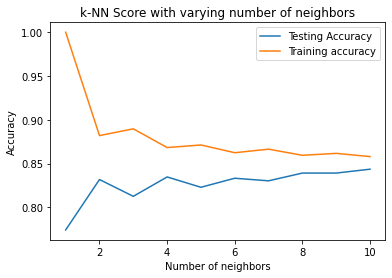

In [41]:
# Generate plot
plt.title('k-NN Score with varying number of neighbors')
x_axis = [i for i in range(1,11)]
plt.plot(x_axis, test_accuracy, label='Testing Accuracy')
plt.plot(x_axis, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Webcan see that test score is increasing as number of neighbours increases.

Let's try to find best parameter for knn.

In [42]:
param_grid = {'n_neighbors':np.arange(1,50)}

In [43]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
knn_cv.best_score_

0.8510324483775811

In [45]:
knn_cv.best_params_

{'n_neighbors': 10}

Text(0.5, 1.0, 'Roc Auc Curve for kNN - 10')

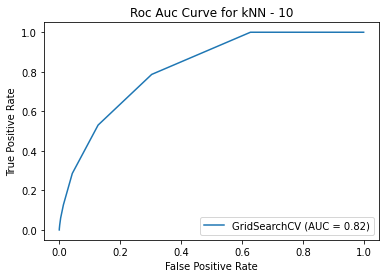

In [46]:
plot_roc_curve(knn_cv,X,Y)
plt.title("Roc Auc Curve for kNN - " + str(knn_cv.best_params_['n_neighbors']))

# **Logistic Regression**

In [47]:
# create and train logistic regression model
logistic_regression_model = LogisticRegression(fit_intercept=True, max_iter=10000)
logistic_regression_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
# Get the model coefficients
logistic_regression_model.coef_

array([[ 0.06385704, -0.02230316,  0.        ,  0.        ,  0.03110369,
        -0.21863703,  1.01841481,  0.03606141,  0.11010395,  0.00270975,
         0.017228  ,  0.00206955, -0.007295  , -0.00847335,  0.00948629]])

In [49]:
# Get the predicted probabilities
train_preds = logistic_regression_model.predict(X_train)
test_preds = logistic_regression_model.predict(X_test)

In [50]:
# Get the accuracy scores
train_accuracy = accuracy_score(train_preds,Y_train)
test_accuracy = accuracy_score(test_preds,Y_test)

print("The accuracy on train data is ", train_accuracy)
print("The accuracy on test data is ", test_accuracy)

The accuracy on train data is  0.8584070796460177
The accuracy on test data is  0.8466076696165191


[[2291   14]
 [ 370   37]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

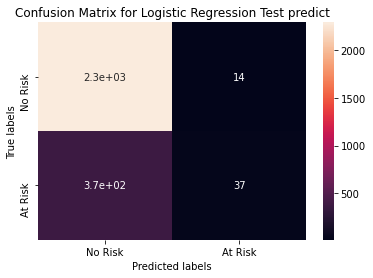

In [51]:
# Get the confusion matrix for train
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(Y_train, train_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Logistic Regression Test predict')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

[[567   7]
 [ 97   7]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

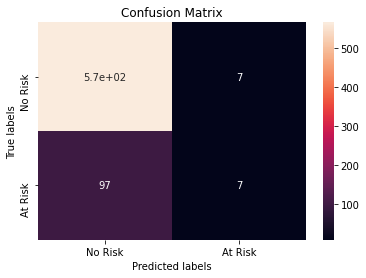

In [52]:
# Get the confusion matrix for test
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(Y_test, test_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [53]:
# print acurracy and roc_auc score
print('ROCAUC score:', roc_auc_score(Y_test, test_preds))
print('Accuracy score:', accuracy_score(Y_test, test_preds))

# Print the classification report for train and test
print(classification_report(Y_train, train_preds))
print("\n")
print(classification_report(Y_test, test_preds))

ROCAUC score: 0.5275562851782364
Accuracy score: 0.8466076696165191
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2305
           1       0.73      0.09      0.16       407

    accuracy                           0.86      2712
   macro avg       0.79      0.54      0.54      2712
weighted avg       0.84      0.86      0.81      2712



              precision    recall  f1-score   support

           0       0.85      0.99      0.92       574
           1       0.50      0.07      0.12       104

    accuracy                           0.85       678
   macro avg       0.68      0.53      0.52       678
weighted avg       0.80      0.85      0.79       678



Even Logistic Regression is not performing better, This is due to imbalance dataset.
We have large number of record that are not at risk and less number of records that are at risk of future coronary heart disease.

Let's Resample the dataset to over come this imbalance.
We will apply SMOTE (Synthetic Minority Oversampling Technique) to resample the data. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors

In [54]:
smote = SMOTE()
# fit predictor and target variable
X_balanced, Y_balanced = smote.fit_resample(cvs_df.iloc[:,0:-1], cvs_df['TenYearCHD'])

In [55]:
print('Original dataset shape', cvs_df.shape)
print('Resampled dataset shape', X_balanced.shape)

Original dataset shape (3390, 16)
Resampled dataset shape (5758, 15)


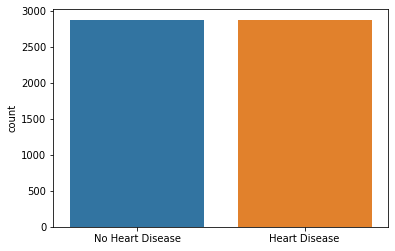

In [56]:
# visualizing the target variable after resample
g = sns.countplot(Y_balanced)
g.set_xticklabels(['No Heart Disease','Heart Disease'])
plt.show()

Now we have balanced dataset so we can apply logistic regression on balanced dataset

In [57]:
# split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=0)

In [58]:
# create and train logistic regression model
logistic_regression_model = LogisticRegression(fit_intercept=True, max_iter=10000)
logistic_regression_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
# Get the model coefficients
logistic_regression_model.coef_

array([[ 7.08753852e-02,  1.34309688e-02,  0.00000000e+00,
         0.00000000e+00,  3.31509302e-02,  4.30551944e-01,
         1.30160194e+00,  2.75739779e-01,  1.17552299e-01,
         2.50195878e-03,  1.16678883e-02, -3.10719699e-03,
         8.21325989e-04, -5.85244058e-03,  7.16999095e-03]])

In [60]:
# Get the predicted probabilities
train_preds = logistic_regression_model.predict(X_train)
test_preds = logistic_regression_model.predict(X_test)

In [61]:
# Get the accuracy scores
train_accuracy = accuracy_score(train_preds,Y_train)
test_accuracy = accuracy_score(test_preds,Y_test)

print("The accuracy on train data is ", train_accuracy)
print("The accuracy on test data is ", test_accuracy)

The accuracy on train data is  0.6804168475900999
The accuracy on test data is  0.6666666666666666


[[355 198]
 [186 413]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

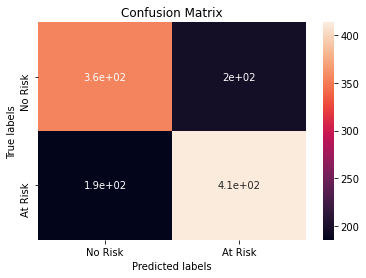

In [62]:
# Get the confusion matrix for test
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(Y_test, test_preds)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [63]:
# print acurracy and roc_auc score
print('ROCAUC score:', roc_auc_score(Y_test, test_preds))
print('Accuracy score:', accuracy_score(Y_test, test_preds))

# Print the classification report for train and test
print(classification_report(Y_train, train_preds))
print("\n")
print(classification_report(Y_test, test_preds))

ROCAUC score: 0.6657177272548884
Accuracy score: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      2326
           1       0.67      0.68      0.68      2280

    accuracy                           0.68      4606
   macro avg       0.68      0.68      0.68      4606
weighted avg       0.68      0.68      0.68      4606



              precision    recall  f1-score   support

           0       0.66      0.64      0.65       553
           1       0.68      0.69      0.68       599

    accuracy                           0.67      1152
   macro avg       0.67      0.67      0.67      1152
weighted avg       0.67      0.67      0.67      1152

